# Auswertung Wärmepumpe und Solaranlage
Installation und Import der notwendigen Pakete im aktiven Environment

In [1]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install matplotlib
import pandas as pd 
import numpy as np
from datetime import datetime
import scipy.interpolate
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

## Eingaben und Annahmen
Heizlast und Heizkurve, Stromverbrauch ohne Heizung, PV-Anlage, Investitionskosten, Verbrauchspreise und erwartete Preissteigerungen

In [2]:
Heizgrenze=16 #Temperatur, ab der nicht mehr geheizt werden muss
Normaussentemperatur=-10
Heizlast_Normaussentemp=10 #Heizlast in kWh bei Normaußentemperatur (normalerweise -10°)
Anzahl_Personen=4
Warmwasserbedarf_pro_Person_pro_Jahr=800 #kWh (Durchschnitt laut thermondo)
Vorlauftemperatur_0deg=35  #Vorlauftemperatur bei 0° Außentemperatur
Vorlauftemperatur_Steigung=-0.55 #Abnahme Vorlauftemperatur pro ° Steigerung Außentemperatur
Warmwassertemperatur=58
Nachtabsenkung_aktiv=True
Nachtabsenkung=0.1 #Absenkung der WP-Leistung Nachts auf X% zwischen 22 und 6 Uhr

Jahresverbrauch=3000 #kWh #Strom-Grundverbrauch
Hausverbrauch_24h = {'Hour':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
        'Verbrauch':[100, 100, 100, 100, 100, 100, 100, 250, 100, 100, 150, 100, 100, 100, 100, 100, 150, 200, 250, 250, 250, 250, 200, 100]}

#PV-Anlage
#-----------------
Installierte_Leistung=9 #in kWp
PVGIS_File="Timeseries_48.277_10.835_SA3_1kWp_crystSi_14_40deg_28deg_2005_2023.csv" #for 1kWp
# Parameter des Akkus
max_kapazitaet = 10  # in kWh
ladeverlust = 0.95   # 95% Effizienz beim Laden
entladeverlust = 0.95  # 95% Effizienz beim Entladen
DoD = 0.8  # Maximaler Entladungsgrad



#Kosten und Preise  ####TODO####
#-----------------


In [3]:
def import_PV(CSV_Filename, installed_kWp):
	#Import hourly data PV from PVGIS for 1kWp and multiply with PV_Leistung
    Header=8
    df = pd.read_csv(CSV_Filename,sep=",", header=Header, low_memory=False)
    df = df.dropna(subset=["P"])
    df = df.dropna(subset=["Int"])
    df.index=pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
    df = df.drop('G(i)', axis=1)
    df = df.drop('H_sun', axis=1)
    df = df.drop('WS10m', axis=1)
    df = df.drop('Int', axis=1)
    df = df.drop('time', axis=1)
    
    df['Month']=df.index.month
    df['Day']=df.index.day
    df['Hour']=df.index.hour
    df["P"] = df.P.astype(float)
    df["P"]=df["P"]*installed_kWp/1000
    DF_PV=df.groupby(['Month', 'Day','Hour']).mean().reset_index()
    DF_PV['Year']=2025
    return DF_PV

DF_PV=import_PV(PVGIS_File, Installierte_Leistung)

In [4]:
#Hausverbrauchs-Tagesgang auf Jahreshausverbrauch skalieren und Werte in Jahres-Dataframe übertragen
def Hausverbrauch(Hausverbrauch_24h, Dataframe_in):
    df_Hausverbrauch = pd.DataFrame(Hausverbrauch_24h)
    #Verbrauchsgang auf Jahresverbrauch Skalieren
    df_Hausverbrauch['Verbrauch']=df_Hausverbrauch['Verbrauch']*((Jahresverbrauch/365)/df_Hausverbrauch['Verbrauch'].sum())
    #plt.plot = df_Hausverbrauch['Verbrauch'].plot(title="Hausverbrauch ohne WP")
    #plt.plot.set_ylim([0, 2])
    #plt.xlabel("Stunde")
    #plt.ylabel("Hausverbrauch[kW]")
    #plt.show()
    df_Hausverbrauch = df_Hausverbrauch.drop('Hour', axis=1)
    Stundenverbrauch=df_Hausverbrauch.T.to_dict(orient='records')[0]
    Dataframe_in['Stromaufnahme_Haus'] = Dataframe_in['Hour'].map(Stundenverbrauch)
    return Dataframe_in

DF_PV=Hausverbrauch(Hausverbrauch_24h, DF_PV)

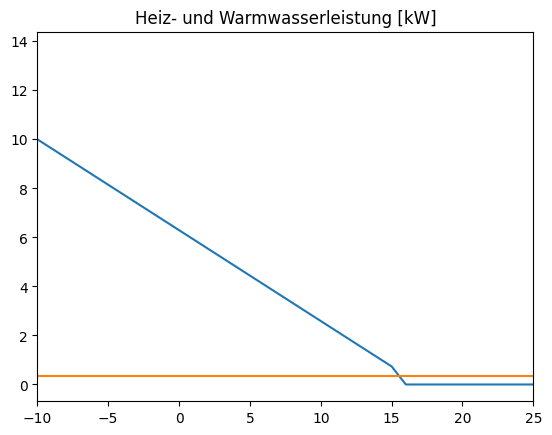

In [5]:
#Heizlast ausrechnen
Heizlast_Warmwasser=Anzahl_Personen*Warmwasserbedarf_pro_Person_pro_Jahr/(365*24)
m=(Heizlast_Normaussentemp-Heizlast_Warmwasser)/(Normaussentemperatur-Heizgrenze)
t=Heizlast_Normaussentemp-(m*Normaussentemperatur)
def Heizlast_berechnen(Dataframe_in):
    Dataframe_in['Heizleistung']=np.where(Dataframe_in['T2m']>=Heizgrenze,0,m*Dataframe_in['T2m']+t)
    Dataframe_in['Warmwasserleistung']=Heizlast_Warmwasser
    return Dataframe_in
DF_PV=Heizlast_berechnen(DF_PV)


#Diese Berechnung dient nur zur Darstellung des Plots
df_Heizkurve = pd.DataFrame(data={'Heizleistung': [0] * 60},
                 index=list(range(-20, 40)))
df_Warmwasserkurve = pd.DataFrame(data={'Warmwasserleistung': [0] * 60},
                 index=list(range(-20, 40)))
df_Heizkurve['Heizleistung']=np.where(df_Heizkurve.index>=Heizgrenze,0,m*df_Heizkurve.index+t)
df_Warmwasserkurve['Warmwasserleistung']=Heizlast_Warmwasser
plot = df_Heizkurve['Heizleistung'].plot()
plot = df_Warmwasserkurve['Warmwasserleistung'].plot(title="Heiz- und Warmwasserleistung [kW]")
plot.set_xlim([-10, 25]);



In [6]:
#TODO: effizienter machen
if Nachtabsenkung_aktiv:
    for j in DF_PV.index:
        if DF_PV.loc[j,'Hour']==0: #Beginn neuer Tag
            Energieaufschub=0
            Energieaufschub_WW=0
            for i in [0,1,2,3,4,5,22,23]:
                Energieaufschub=Energieaufschub+(1-Nachtabsenkung)*DF_PV.loc[(j+i),'Heizleistung']
                Energieaufschub_WW=Energieaufschub_WW+(1-Nachtabsenkung)*DF_PV.loc[(j+i),'Warmwasserleistung']
                DF_PV.loc[(j+i),'Heizleistung']=Nachtabsenkung*DF_PV.loc[(j+i),'Heizleistung']
                DF_PV.loc[(j+i),'Warmwasserleistung']=Nachtabsenkung*DF_PV.loc[(j+i),'Warmwasserleistung']             
            for i in [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
                DF_PV.loc[(j+i),'Heizleistung']=DF_PV.loc[(j+i),'Heizleistung']+Energieaufschub/16
                DF_PV.loc[(j+i),'Warmwasserleistung']=DF_PV.loc[(j+i),'Warmwasserleistung']+Energieaufschub_WW/16

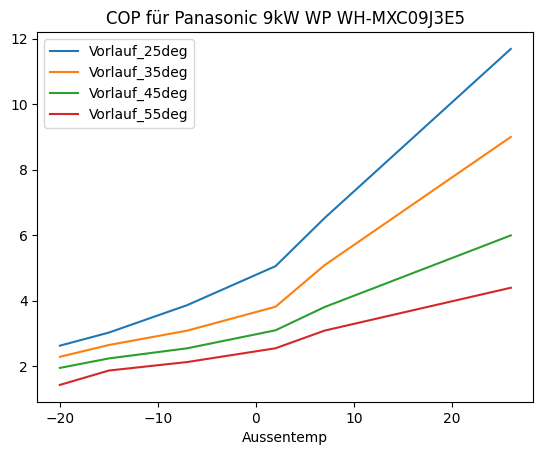

In [7]:
#COP Wärmepumpe nach Vorlauftemp und Außentemperatur
#WH-MXC09J3E5 Volllast == WH-MXC12J6E5 auf 75 % == WH-MXC16J9E8 auf 56 %
COP = {'Aussentemp':[-20,-15,-7,2,7,26],
        'Vorlauf_25deg':[2.62,3.02,3.86,5.05,6.52,11.69],
        'Vorlauf_35deg':[2.28,2.64,3.08,3.81,5.08,9.00],
        'Vorlauf_45deg':[1.94,2.23,2.54,3.09,3.80,5.99],
        'Vorlauf_55deg':[1.42,1.86,2.12,2.54,3.08,4.39],
      }
df_COP = pd.DataFrame(COP).set_index('Aussentemp')
df_COP.plot(title="COP für Panasonic 9kW WP WH-MXC09J3E5");

In [8]:
x=np.array(df_COP.index.values)
y=np.array([[25],[35],[45],[55]])
z=np.array([df_COP['Vorlauf_25deg'].values, df_COP['Vorlauf_35deg'].values, df_COP['Vorlauf_45deg'].values, df_COP['Vorlauf_55deg'].values])
f = RectBivariateSpline(x,y,np.transpose(z))
#Z2 = f(-18, 42) # Test (aussentemperatur, Vorlauftemperatur)


for j in DF_PV.index:
    Vorlauftemperatur_calc=(Vorlauftemperatur_Steigung*DF_PV.loc[j,'T2m']+Vorlauftemperatur_0deg)
    COP_calc_Heiz=f(DF_PV.loc[j,'T2m'], Vorlauftemperatur_calc)
    COP_calc_Warmwasser=f(DF_PV.loc[j,'T2m'], Warmwassertemperatur)
    DF_PV.loc[j,'COP_WP_Heiz']=COP_calc_Heiz.item(0)
    DF_PV.loc[j,'COP_WP_Warmwasser']=COP_calc_Warmwasser.item(0)

DF_PV['Stromaufnahme_WP_Heiz']=DF_PV['Heizleistung']/DF_PV['COP_WP_Heiz']
DF_PV['Stromaufnahme_WP_Warmwasser']=DF_PV['Warmwasserleistung']/DF_PV['COP_WP_Warmwasser']

In [9]:
#Jahresarbeitszahl-Auswertung
df_Jahressummen=DF_PV.groupby('Year').agg({'P':'sum', 'T2m':'mean','Heizleistung':'sum','Warmwasserleistung':'sum','Stromaufnahme_WP_Heiz':'sum','Stromaufnahme_WP_Warmwasser':'sum','Stromaufnahme_Haus':'sum'})
display(df_Jahressummen)

JAZ_WP_Heiz=df_Jahressummen.at[2025,'Heizleistung']/df_Jahressummen.at[2025,'Stromaufnahme_WP_Heiz']
JAZ_WP_Warmwasser=df_Jahressummen.at[2025,'Warmwasserleistung']/df_Jahressummen.at[2025,'Stromaufnahme_WP_Warmwasser']
JAZ_combined=(df_Jahressummen.at[2025,'Heizleistung']+df_Jahressummen.at[2025,'Warmwasserleistung'])/(df_Jahressummen.at[2025,'Stromaufnahme_WP_Heiz']+df_Jahressummen.at[2025,'Stromaufnahme_WP_Warmwasser'])
print(JAZ_WP_Heiz,JAZ_WP_Warmwasser,JAZ_combined)

,P,T2m,Heizleistung,Warmwasserleistung,Stromaufnahme_WP_Heiz,Stromaufnahme_WP_Warmwasser,Stromaufnahme_Haus
Year,,,,,,,
2025,9875.544417,9.54692,25943.757604,3208.767123,5643.255893,967.511171,3008.219178


4.597303063057343 3.3165168717734472 4.409855080692908


In [10]:
def Speicherauswertung(Dataframe_in):
    Dataframe_in["Verbrauch"]=Dataframe_in["Stromaufnahme_WP_Heiz"]+Dataframe_in["Stromaufnahme_WP_Warmwasser"]+Dataframe_in["Stromaufnahme_Haus"]
    # Mindestkapazität des Akkus
    min_kapazitaet = max_kapazitaet * (1 - DoD)
    
    # Initialisierung der neuen Spalten
    Dataframe_in["Netzbezug"] = 0.0
    Dataframe_in["Speicherzustand"] = 0.0
    Dataframe_in["Direkte_PV_Nutzung"] = 0.0
    Dataframe_in["Akkunutzung"] = 0.0
    Dataframe_in["NetzEinspeisung"] = 0.0
    
    # Anfangszustand des Akkus
    aktueller_speicher = max_kapazitaet*(1 - DoD) # Speicher leer zu Beginn
    
    # Iteration durch den DataFrame
    for index, row in Dataframe_in.iterrows():
        pv = row["P"]
        verbrauch = row["Verbrauch"]
        ueberschuss = pv - verbrauch  # Positiv = Überschuss, Negativ = Defizit
    
        if ueberschuss >= 0:  # PV-Erzeugung reicht aus
            # Direkte PV-Nutzung
            Dataframe_in.at[index, "Direkte_PV_Nutzung"] = verbrauch
            # Berechnung der freien Kapazität im Akku
            freie_kapazitaet = max_kapazitaet - aktueller_speicher
    
            # Berechnung der Ladeenergie für den Akku, wobei Ladeverlust berücksichtigt wird
            ladung = ueberschuss * ladeverlust
    
            # Wenn die Ladeenergie die freie Kapazität überschreiten würde, dann nur bis zur maximalen Kapazität laden
            ladung_tatsaechlich = min(ladung, freie_kapazitaet)
    
            # Der Akku wird nur mit der verfügbaren Energie geladen
            aktueller_speicher = min(max_kapazitaet, aktueller_speicher + ladung_tatsaechlich)
    
            # Berechnung der NetzEinspeisung: Wenn der Akku voll ist, wird der überschüssige Strom ins Netz eingespeist
            Dataframe_in.at[index, "NetzEinspeisung"] = max(0.0, ueberschuss - ladung_tatsaechlich)
        else:  # PV-Erzeugung reicht nicht aus
            # Direkte PV-Nutzung (maximal PV-Erzeugung)
            Dataframe_in.at[index, "Direkte_PV_Nutzung"] = pv
            bedarf = -ueberschuss  # Fehlender Verbrauch
            # Energie aus dem Akku entnehmen (bis zur minimalen Kapazität)
            maximal_entnahme = (aktueller_speicher - min_kapazitaet) * entladeverlust
            entnahme = min(maximal_entnahme, bedarf)
            aktueller_speicher -= entnahme / entladeverlust  # Verluste berücksichtigen
            Dataframe_in.at[index, "Akkunutzung"] = entnahme
            # Netzbezug für den restlichen Bedarf
            Dataframe_in.at[index, "Netzbezug"] = max(0.0, bedarf - entnahme)
            Dataframe_in.at[index, "NetzEinspeisung"] = 0.0  # Kein Überschuss zum Einspeisen
    
        # Speicherzustand aktualisieren
        Dataframe_in.at[index, "Speicherzustand"] = aktueller_speicher
    return Dataframe_in



<Axes: >

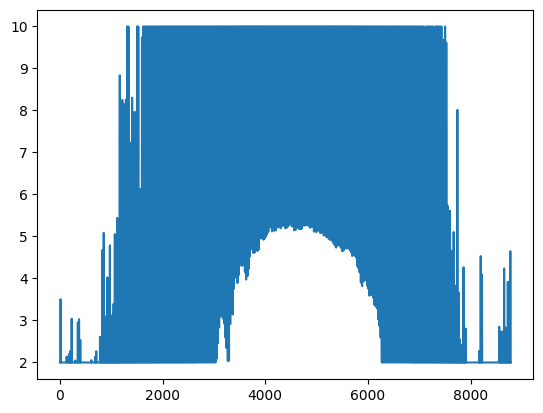

In [11]:
DF_PV=Speicherauswertung(DF_PV)
DF_PV['Speicherzustand'].plot()


In [12]:
df_Jahressummen=DF_PV.groupby('Year').agg({'P':'sum','Verbrauch':'sum', 'Netzbezug':'sum', 'NetzEinspeisung':'sum', 'Direkte_PV_Nutzung':'sum', 'Akkunutzung':'sum'}).round(0)
display(df_Jahressummen)

,P,Verbrauch,Netzbezug,NetzEinspeisung,Direkte_PV_Nutzung,Akkunutzung
Year,,,,,,
2025,9876.0,9619.0,4458.0,4623.0,3426.0,1735.0
